In [7]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize)
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm


In [8]:
import numpy as np
import pandas as pd
Boston=load_data('Boston')

# (a)

In [19]:
dis = Boston['dis'] # predicctor
nox = Boston['nox'] # response
# Use ploy() to predict nox using dis. Repost regression output, and plot the resulting data and polinomial fit.
poly_dis = MS([poly('dis', degree=3)]).fit(Boston)
M = sm.OLS(nox, poly_dis.transform(Boston)).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


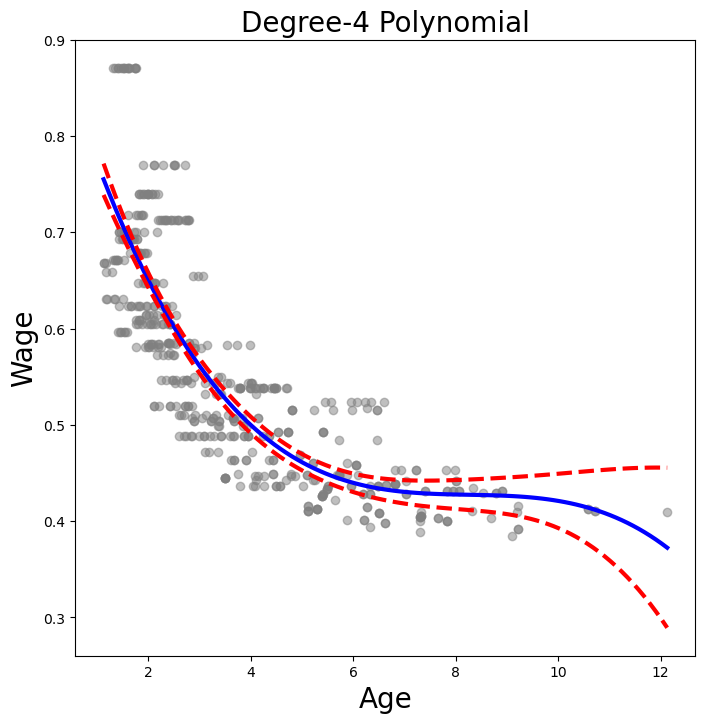

In [18]:
dis_grid = np.linspace(dis.min(),
                       dis.max(),
                       100)
dis_df = pd.DataFrame({'dis': dis_grid})
def plot_wage_fit(dis_df, 
                  basis,
                  title):

    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(nox, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
               nox,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax
plot_wage_fit(dis_df, 
              poly_dis,
              'Degree-4 Polynomial');


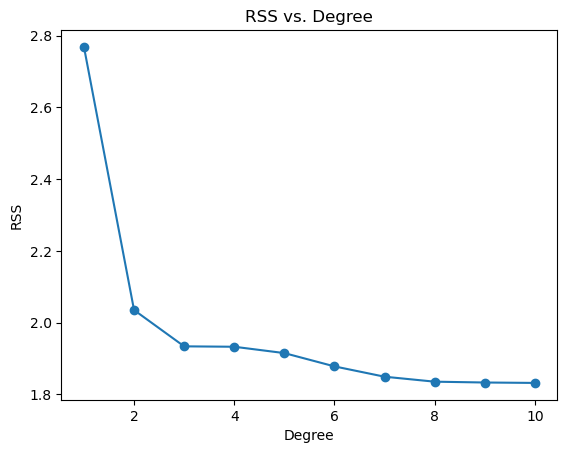

In [20]:
#(b) Plot polynomial fist 1 to 10 degree, report residual sum of squares
# Test for various polynomial degrees: 1 to 10 and report residual sum of squares
degrees = np.arange(1, 11)
results = []
for degree in degrees:
    basis = MS([poly('dis', degree=degree)]).fit(Boston)
    M = sm.OLS(nox, basis.transform(Boston)).fit()
    results.append(M.ssr)
results = pd.Series(results, index=degrees)
results.plot(marker='o')
plt.xlabel('Degree')
plt.ylabel('RSS')
plt.title('RSS vs. Degree');


3

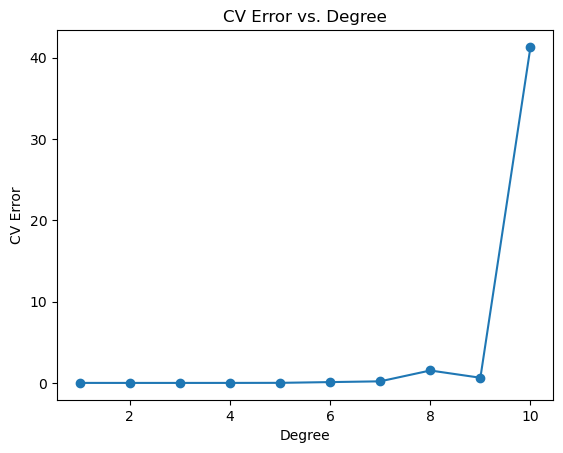

In [21]:
# (c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results. 
# Cross-validation to select the optimal degree for the polynomial
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Create a pipeline that standardizes, creates polynomial features, and fits a linear regression model
def cv(degree):
    model = make_pipeline(PolynomialFeatures(degree),
                          LinearRegression())
    return -cross_val_score(model,
                            pd.DataFrame(dis),
                            nox,
                            cv=KFold(10),
                            scoring='neg_mean_squared_error').mean()
results = pd.Series({degree: cv(degree) for degree in degrees})
results.plot(marker='o')
plt.xlabel('Degree')
plt.ylabel('CV Error')
plt.title('CV Error vs. Degree');
results.idxmin()


In [30]:
def plot_nox_fit(dis_df, 
                  basis,
                  title):

    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(nox, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
               nox,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);
    return ax

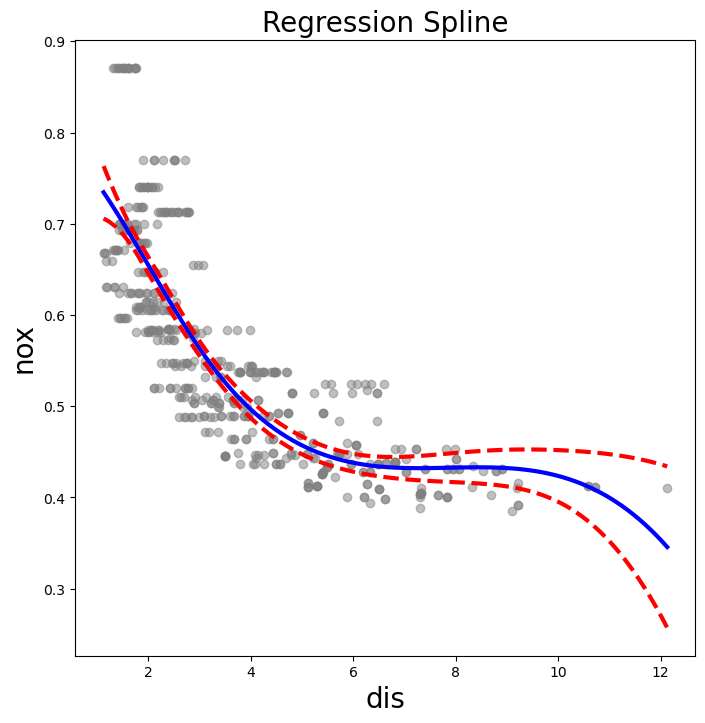

In [31]:
# Based on the rss plot and the cross-validation, the optimal degree for the polynomial is 3.
# (d) Use the bs() function to fit a regression spline to predict nox using dis. 
# Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.
from ISLP.models import bs
basis = MS([bs('dis', df=4)]).fit(Boston)
M = sm.OLS(nox, basis.transform(Boston)).fit()
summarize(M)
plot_nox_fit(dis_df, 
              basis,
              'Regression Spline');
# knots were chosen based on the distribution of the predictor variable dis.
# That is, the knots were chosen to be evenly spaced along the range of the predictor variable dis, 
# with the number of knots being equal to the degrees of freedom.

14

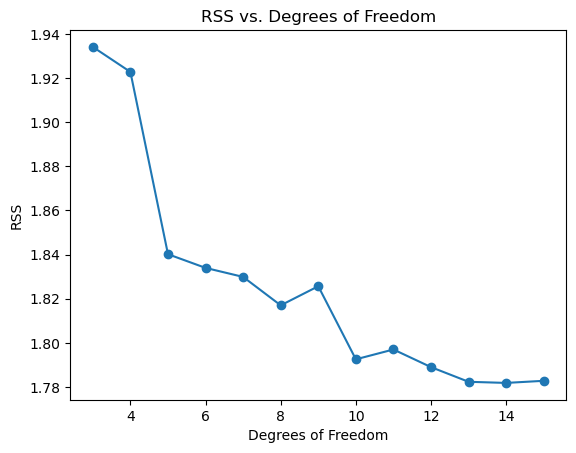

In [23]:
# (e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. 
# Describe the results obtained.
degrees = np.arange(3, 16)
results = []
for df in degrees:
    basis = MS([bs('dis', df=df)]).fit(Boston)
    M = sm.OLS(nox, basis.transform(Boston)).fit()
    results.append(M.ssr)
results = pd.Series(results, index=degrees)
results.plot(marker='o')
plt.xlabel('Degrees of Freedom')
plt.ylabel('RSS')
plt.title('RSS vs. Degrees of Freedom');
results.idxmin()
# The RSS decreases as the degrees of freedom increase. The optimal degrees of freedom for the regression spline is 15.


3

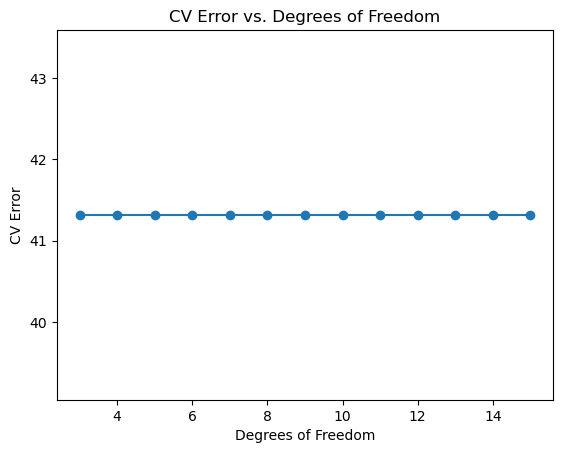

In [26]:
# (f) Perform cross-validation or another approach to select the optimal degrees of freedom for the regression spline, and explain your results.
# Cross-validation to select the optimal degrees of freedom for the regression spline
def cv(df):
    model = make_pipeline(PolynomialFeatures(degree),
                          LinearRegression())
    return -cross_val_score(model,
                            pd.DataFrame(dis),
                            nox,
                            cv=KFold(10),
                            scoring='neg_mean_squared_error').mean()
results = pd.Series({df: cv(df) for df in degrees})
results.plot(marker='o')
plt.xlabel('Degrees of Freedom')
plt.ylabel('CV Error')
plt.title('CV Error vs. Degrees of Freedom');
results.idxmin()
# Based on the rss plot and the cross-validation, the optimal degrees of freedom for the regression spline is 15.